In [4]:
import pandas as pd
import numpy as np
import requests
#!conda install --yes anaconda beautifulsoup4 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [5]:
from bs4 import BeautifulSoup

# Data Acquisition 1

### Get data from wikipedia with Beautiful Soup

We want the third table on the wikipedia page, listing all neighbourhoods in berlin with their respective borough and information on area and population

In [14]:
page = requests.get("https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins")
soup = BeautifulSoup(page.content,'lxml')
table = soup.find_all('table')[2]
df = pd.read_html(str(table))[0]
df.head()

,Nr.,Ortsteil,Bezirk,Fläche(km²),Einwohner[2](30. Juni 2019),Einwohnerpro km²
0,101,Mitte,Mitte,1070,101.932,9526.000
1,102,Moabit,Mitte,772,79.512,10.299
2,103,Hansaviertel,Mitte,53,5.894,11.121
3,104,Tiergarten,Mitte,517,14.753,2854.000
4,105,Wedding,Mitte,923,86.688,9392.000


# Data Cleaning 1

Translate column names into english

In [15]:
df.rename(columns={'Ortsteil' : 'Neighbourhood', 'Bezirk' : 'Borough', 'Fläche(km²)' : 'Area', 'Einwohner[2](30. Juni 2019)' : 'Population', 'Einwohnerpro km²' : 'Population Density'}, inplace = True)
df.rename(columns={df.columns[4] : 'Population'}, inplace = True)
df.head()

,Nr.,Neighbourhood,Borough,Area,Population,Population Density
0,101,Mitte,Mitte,1070,101.932,9526.000
1,102,Moabit,Mitte,772,79.512,10.299
2,103,Hansaviertel,Mitte,53,5.894,11.121
3,104,Tiergarten,Mitte,517,14.753,2854.000
4,105,Wedding,Mitte,923,86.688,9392.000


Area needs to be translated as comma was ignored by Beautiful Soup.

In [16]:
df['Area'] = df['Area'].apply(lambda x: x/100)
df.head()

,Nr.,Neighbourhood,Borough,Area,Population,Population Density
0,101,Mitte,Mitte,10.70,101.932,9526.000
1,102,Moabit,Mitte,7.72,79.512,10.299
2,103,Hansaviertel,Mitte,0.53,5.894,11.121
3,104,Tiergarten,Mitte,5.17,14.753,2854.000
4,105,Wedding,Mitte,9.23,86.688,9392.000


Malchwo, being the only neighbourhood with fewer than 1000 inhabitants needs to be changed, since bs4 interpreteed the population column to be in thousands, and hence turned Malchow's population of 636 into 630k.

In [17]:
df[df['Neighbourhood'] == 'Malchow']

,Nr.,Neighbourhood,Borough,Area,Population,Population Density
79,1106,Malchow,Lichtenberg,1.54,636.0,413.0


In [18]:
df.loc[df.Neighbourhood=='Malchow', 'Population'] = .636

In [19]:
df[df['Neighbourhood'] == 'Malchow']

,Nr.,Neighbourhood,Borough,Area,Population,Population Density
79,1106,Malchow,Lichtenberg,1.54,0.636,413.0


# Data Acquisition 2

In [ ]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

### Coordinates

Get geospatial data about neighbourhoods

In [ ]:
lat = np.zeros(len(df))
long = np.zeros(len(df))
idx = 0

for address in df['Neighbourhood']:
    address = address + ', Berlin, Germany'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    lat[idx] = location.latitude
    long[idx] = location.longitude
    print(address + " lat:" + str(lat[idx])+ " long:" + str(long[idx]))
    idx = idx+1

Add coordinates to DataFrame

In [22]:
df['Latitude'] = lat
df['Longitude'] = long
df.head()

,Nr.,Neighbourhood,Borough,Area,Population,Population Density,Latitude,Longitude
0,101,Mitte,Mitte,10.70,101.932,9526.000,52.517690,13.402376
1,102,Moabit,Mitte,7.72,79.512,10.299,52.530102,13.342542
2,103,Hansaviertel,Mitte,0.53,5.894,11.121,52.519123,13.341872
3,104,Tiergarten,Mitte,5.17,14.753,2854.000,52.509778,13.357260
4,105,Wedding,Mitte,9.23,86.688,9392.000,52.550123,13.341970


 ### Write to CSV

Write data to csv file in order to avoid having to rerun above code

In [23]:
df.to_csv(path_or_buf = 'data/Berlin.csv')

# START CODE FROM HERE

In [7]:
df = pd.read_csv('data/Berlin.csv')
df.drop(columns = df.columns[0], inplace = True)
df.head()

,Nr.,Neighbourhood,Borough,Area,Population,Population Density,Latitude,Longitude
0,101,Mitte,Mitte,10.70,101.932,9526.000,52.517690,13.402376
1,102,Moabit,Mitte,7.72,79.512,10.299,52.530102,13.342542
2,103,Hansaviertel,Mitte,0.53,5.894,11.121,52.519123,13.341873
3,104,Tiergarten,Mitte,5.17,14.753,2854.000,52.509778,13.357260
4,105,Wedding,Mitte,9.23,86.688,9392.000,52.550123,13.341970


# Data Cleaning 2

No need for Population Density. Borough is interesting, but not useful for our purpose. The Number column lists the first three digits of postal codes in tat neighbourhood. Also interesting but of no use to us. Lets drop them all.

In [8]:
df.drop(columns = ['Population Density', 'Borough', 'Nr.'], inplace = True)

In [33]:
df.head()

,Neighbourhood,Area,Population,Latitude,Longitude
0,Mitte,10.70,101.932,52.517690,13.402376
1,Moabit,7.72,79.512,52.530102,13.342542
2,Hansaviertel,0.53,5.894,52.519123,13.341873
3,Tiergarten,5.17,14.753,52.509778,13.357260
4,Wedding,9.23,86.688,52.550123,13.341970


# Data Acqusition 3

Define Foursquare Credentials

In [34]:
{
    "tags": [
        "remove_input",
    ]
}
# @hiddencell
CLIENT_ID = 'CDMYBZVXX554L3PXEICH5CH0ZDL3TRZNPY2XPNRNMFXOXZZU' # your Foursquare ID
CLIENT_SECRET = '0KGS1CBFIJYC30ADVTXO5JAR4O3EE25VHKAMWEEG2JIXNK5X' # your Foursquare Secret
VERSION = '20193027' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Define function to get venue category

In [35]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Define function to get nearby venues

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radiuses):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radiuses):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            200)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Calculate radius

In [9]:
import math

Since the neighbourhoods are of different sizes, we want to have a different radius for each neighbourhood based on the neighbourhoods area, in order to get venues that approximately within that neighbourhood. Radius needs to be in meters for the FourSquare API.

In [10]:
df['Radius'] = df['Area'].apply(lambda x: np.sqrt(x/math.pi)*1000)
df.head()

,Neighbourhood,Area,Population,Latitude,Longitude,Radius
0,Mitte,10.70,101.932,52.517690,13.402376,1845.512336
1,Moabit,7.72,79.512,52.530102,13.342542,1567.594438
2,Hansaviertel,0.53,5.894,52.519123,13.341873,410.736217
3,Tiergarten,5.17,14.753,52.509778,13.357260,1282.833626
4,Wedding,9.23,86.688,52.550123,13.341970,1714.059582


Get venues.

In [ ]:
LIMIT = 200
berlin_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                 radiuses=df['Radius']
                                  )


In [42]:
berlin_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.51769,13.402376,Lustgarten,52.518469,13.399454,Garden
1,Mitte,52.51769,13.402376,Radisson Blu,52.519580,13.402730,Hotel
2,Mitte,52.51769,13.402376,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout
3,Mitte,52.51769,13.402376,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum
4,Mitte,52.51769,13.402376,Deutsches Historisches Museum,52.517788,13.396948,History Museum


Take a look at the venue distribution

In [38]:

venue_counts = berlin_venues.groupby('Neighbourhood').count()['Venue']
venue_counts

Neighbourhood
Adlershof                     34
Alt-Hohenschönhausen          61
Alt-Treptow                   65
Altglienicke                  14
Baumschulenweg                23
Biesdorf                      30
Blankenburg                    5
Blankenfelde                  10
Bohnsdorf                     16
Borsigwalde                   12
Britz                         52
Buch                          15
Buckow                        10
Charlottenburg               100
Charlottenburg-Nord           23
Dahlem                        52
Falkenberg                     5
Falkenhagener Feld            14
Fennpfuhl                     30
Französisch Buchholz           9
Friedenau                     64
Friedrichsfelde               56
Friedrichshagen               45
Friedrichshain               100
Frohnau                       24
Gatow                         14
Gesundbrunnen                100
Gropiusstadt                  28
Grunewald                    100
Grünau                       

In [44]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 339 uniques categories.


Save DataFrame as csv (becuase of limited number of API class we dont want to rerun the code)

In [45]:
berlin_venues.to_csv(path_or_buf = 'data/berlin_venues.csv')

# Data Cleaning (3) and Feature Selection

Load venue data

In [35]:
berlin_venues = []
berlin_venues = pd.read_csv('data/berlin_venues.csv')
berlin_venues.drop(columns = berlin_venues.columns[0], inplace = True)

In [39]:
berlin_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.51769,13.402376,Lustgarten,52.518469,13.399454,Garden
1,Mitte,52.51769,13.402376,Radisson Blu,52.519580,13.402730,Hotel
2,Mitte,52.51769,13.402376,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout
3,Mitte,52.51769,13.402376,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum
4,Mitte,52.51769,13.402376,Deutsches Historisches Museum,52.517788,13.396948,History Museum


### Remove venues by category

Since we are only interested in venues that are buisnesse that provide a service, we need to remove all others. Additionally some cleaning is in order. For example, it is simple not true that there are only 3 pharmacies in all of Berlin, so it stands to reason that most are not listed. So we are going to remove the three that are listed as well. Also Zoo exhibits are listed seperately in their own category, in addition to the Zoo they are in. This disproportionally lends weight to the Zoo, so we are going to remove the Zoo Exhibits category, and only leave the Zoo in. The same holds for Theme Park Attraction / Ride. We are only leaving the Theme Parks themselves in the data.

In [40]:
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'ATM']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Animal Shelter']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Airport Service']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Beach']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Boat or Ferry']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Bathing Area']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Building']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Bus Stop']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Campground']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Canal']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Castle']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Cemetary']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Construction & Landscaping']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Fair']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Flea Market']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Fish Market']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Fountain']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Field']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Forest']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Post Office']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Garden']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Historic Site']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Harbor / Marina']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Intersection']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Lake']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Light Rail Station']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Memorial Site']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Metro Station']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Monument / Landmark']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Mountain']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Nature Preserve']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Neighborhood']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Outdoor Sculpture']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Palace']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Park']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Pedestrian Plaza']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Pier']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Platform']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Plaza']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Public Art']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'River']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Sculpture Garden']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Scenic Lookout']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'School']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Street Art']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Soccer Field']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Soccer Stadium']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Tram Station']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Train Station']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Trail']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Tree']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Tunnel']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Theme Park Ride / Attraction']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Waterfront']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Zoo Exhibit']
berlin_venues = berlin_venues[berlin_venues['Venue Category'] != 'Pharmacy']

For inspection of Data. (Output removed, takes too much space).

In [ ]:
pd.set_option('display.max_rows', 500)
berlin_venues.groupby('Neighbourhood').count()

# Feature Engineering

One Hot encode the venue categories.

In [41]:
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")
berlin_onehot['Neighbourhood'] = berlin_venues['Neighbourhood'] 
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot

,Neighbourhood,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo
1,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,Borsigwalde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4272,Borsigwalde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4273,Borsigwalde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4274,Borsigwalde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculate frequencies

In [42]:
berlin_grouped = berlin_onehot.groupby('Neighbourhood').mean().reset_index()

### Create Top 10 venue listing

Define function

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Use it to get Top 10

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = berlin_grouped['Neighbourhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Supermarket,Café,Hotel,Greek Restaurant,Drugstore,Cafeteria,Movie Theater,Coffee Shop,Steakhouse,Sushi Restaurant
1,Alt-Hohenschönhausen,Supermarket,Drugstore,Bakery,Café,Shopping Mall,German Restaurant,Automotive Shop,Greek Restaurant,Ice Cream Shop,Steakhouse
2,Alt-Treptow,Nightclub,Italian Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Concert Hall,Beer Garden,Big Box Store,Gift Shop,Supermarket
3,Altglienicke,Supermarket,Diner,Bakery,Greek Restaurant,Automotive Shop,Stadium,Bowling Alley,Indian Restaurant,Football Stadium,Food Truck
4,Baumschulenweg,Supermarket,Café,Drugstore,Gym / Fitness Center,Shipping Store,Tennis Court,Vietnamese Restaurant,Asian Restaurant,Gas Station,Garden Center


# Analysis

We are going to use the relative frequencies of venue categories for each enighbourhood to cluster them into groups of neighbourhoods of similar venue makeup.

### Clustering

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Find the optimal k for the data with the Silhouette Score.

In [44]:
# set number of clusters
k_max = 12
silScore = np.zeros(k_max+1)

berlin_grouped_clustering = berlin_grouped.drop('Neighbourhood', 1)

# run k-means clustering
for kclusters in range(2,k_max+1):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)
    silScore[kclusters] = silhouette_score(berlin_grouped_clustering, kmeans.labels_)


### Visualization

Plot Silhouette score for each k to visualize performance development for k.

In [2]:
#!conda install nodejs --yes
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib

In [3]:
from matplotlib import pyplot as plt

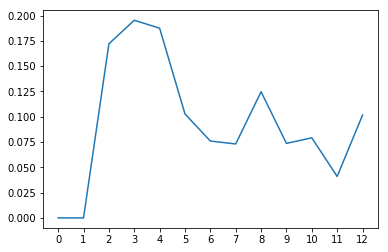

In [45]:
%matplotlib inline
ax = plt.plot(silScore, label = 'linear')
plt.xticks(range(0,k_max+1));

In [46]:
kmeans = KMeans(n_clusters=silScore.argmax(), random_state=0).fit(berlin_grouped_clustering)

In [20]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(berlin_grouped_clustering)

In [47]:
kmeans.labels_


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0], dtype=int32)

### Create DataFrame for different visualization pourposes.

Create DataFrame including Cluster Number and Top Venues

In [60]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [61]:
berlin_merged = df
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='inner')

In [49]:
venue_counts = berlin_venues.groupby(['Neighbourhood']).count()

In [50]:
venue_counts = venue_counts['Venue']

In [51]:
venue_counts = venue_counts.reset_index()

In [62]:
berlin_merged = berlin_merged.join(venue_counts.set_index('Neighbourhood'), on='Neighbourhood', how='inner')


In [63]:
berlin_merged.head()

,Neighbourhood,Area,Population,Latitude,Longitude,Radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
0,Mitte,10.70,101.932,52.517690,13.402376,1845.512336,0,Hotel,Bookstore,History Museum,Coffee Shop,Café,Indie Movie Theater,Optical Shop,Vegetarian / Vegan Restaurant,Gourmet Shop,Sandwich Place,88
1,Moabit,7.72,79.512,52.530102,13.342542,1567.594438,0,Café,Turkish Restaurant,Vietnamese Restaurant,Bar,Restaurant,Coffee Shop,Trattoria/Osteria,Italian Restaurant,Gym / Fitness Center,Cocktail Bar,93
2,Hansaviertel,0.53,5.894,52.519123,13.341873,410.736217,0,Art Museum,Café,Sporting Goods Shop,Supermarket,Theater,Bistro,Kebab Restaurant,Turkish Restaurant,Mediterranean Restaurant,Convenience Store,16
3,Tiergarten,5.17,14.753,52.509778,13.357260,1282.833626,0,Hotel,Concert Hall,Italian Restaurant,Hotel Bar,Art Gallery,Art Museum,Bar,Indie Movie Theater,Museum,Music Venue,84
4,Wedding,9.23,86.688,52.550123,13.341970,1714.059582,0,Café,Bar,Ice Cream Shop,Drugstore,Turkish Restaurant,Korean Restaurant,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Brewery,94


Calculate 'Venue Density' as number of venues per 1000 citizens. Note that the calculated number will be lower than the actual number for all neighbourhoods with more than 100 venues, since the FourSquare API only returns 100 venues. They also have fewer than 100 venues in our current DataFrame since we remove some venues, but odds are there are more venues of the more frequent types that just didnt make it into the original DataFrame because of FourSquares limitation to 100 venues. However, the density for those neighbourhoods is not too important for our analysis anyways.

In [64]:
berlin_merged['Venue Density'] = berlin_merged.Venue / berlin_merged.Population
berlin_merged.rename(columns={'Venue' : 'N_venues'}, inplace = True) 

In [65]:
berlin_merged.head()

,Neighbourhood,Area,Population,Latitude,Longitude,Radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,N_venues,Venue Density
0,Mitte,10.70,101.932,52.517690,13.402376,1845.512336,0,Hotel,Bookstore,History Museum,Coffee Shop,Café,Indie Movie Theater,Optical Shop,Vegetarian / Vegan Restaurant,Gourmet Shop,Sandwich Place,88,0.863321
1,Moabit,7.72,79.512,52.530102,13.342542,1567.594438,0,Café,Turkish Restaurant,Vietnamese Restaurant,Bar,Restaurant,Coffee Shop,Trattoria/Osteria,Italian Restaurant,Gym / Fitness Center,Cocktail Bar,93,1.169635
2,Hansaviertel,0.53,5.894,52.519123,13.341873,410.736217,0,Art Museum,Café,Sporting Goods Shop,Supermarket,Theater,Bistro,Kebab Restaurant,Turkish Restaurant,Mediterranean Restaurant,Convenience Store,16,2.714625
3,Tiergarten,5.17,14.753,52.509778,13.357260,1282.833626,0,Hotel,Concert Hall,Italian Restaurant,Hotel Bar,Art Gallery,Art Museum,Bar,Indie Movie Theater,Museum,Music Venue,84,5.693757
4,Wedding,9.23,86.688,52.550123,13.341970,1714.059582,0,Café,Bar,Ice Cream Shop,Drugstore,Turkish Restaurant,Korean Restaurant,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Brewery,94,1.084348


### Map Visualization

Get Coordinates for Toronto

In [57]:
address = 'Berlin'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


Make map with Folium

In [58]:
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors


Create map.

In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighbourhood'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine lusters

### Cluster 0

This is the important cluster- It contains all the upper scale neighbourhoods like Mitte, Kreuzberg, Friedrichshain and so on. These neighbourhoods have a similar makeup of venues, and thus the potential candidates can be found in this cluster as well.

In [67]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(6, berlin_merged.shape[1]-2))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mitte,0,Hotel,Bookstore,History Museum,Coffee Shop,Café,Indie Movie Theater,Optical Shop,Vegetarian / Vegan Restaurant,Gourmet Shop,Sandwich Place
1,Moabit,0,Café,Turkish Restaurant,Vietnamese Restaurant,Bar,Restaurant,Coffee Shop,Trattoria/Osteria,Italian Restaurant,Gym / Fitness Center,Cocktail Bar
2,Hansaviertel,0,Art Museum,Café,Sporting Goods Shop,Supermarket,Theater,Bistro,Kebab Restaurant,Turkish Restaurant,Mediterranean Restaurant,Convenience Store
3,Tiergarten,0,Hotel,Concert Hall,Italian Restaurant,Hotel Bar,Art Gallery,Art Museum,Bar,Indie Movie Theater,Museum,Music Venue
4,Wedding,0,Café,Bar,Ice Cream Shop,Drugstore,Turkish Restaurant,Korean Restaurant,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Brewery
5,Gesundbrunnen,0,Bar,Café,Bakery,Coffee Shop,Vietnamese Restaurant,Restaurant,Ice Cream Shop,Italian Restaurant,Supermarket,Dance Studio
6,Friedrichshain,0,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Nightclub,Bar,Ice Cream Shop,Middle Eastern Restaurant,Thai Restaurant,Pizza Place,Falafel Restaurant
7,Kreuzberg,0,Coffee Shop,Bar,Café,Turkish Restaurant,Indie Movie Theater,Bakery,Pizza Place,Wine Bar,Art Gallery,Yoga Studio
8,Prenzlauer Berg,0,Café,Vietnamese Restaurant,Ice Cream Shop,Bakery,Cocktail Bar,Coffee Shop,Bar,Falafel Restaurant,Beer Bar,Wine Bar
9,Weißensee,0,Supermarket,Hotel,Automotive Shop,Fast Food Restaurant,Greek Restaurant,Café,Organic Grocery,Drugstore,German Restaurant,Indoor Play Area


### Cluster 1

This cluster contains the lower-scale neighbourhoods that are mostly dominated by supermarkets, drug-stores and cheap restaurants.

In [68]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(6, berlin_merged.shape[1]-2))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Karow,1,Supermarket,Bakery,Café,German Restaurant,Restaurant,BBQ Joint,Doner Restaurant,Zoo,Flower Shop,Farm
14,Pankow,1,Supermarket,Gas Station,Greek Restaurant,Bakery,Electronics Store,Drugstore,Organic Grocery,Asian Restaurant,Pet Store,Flower Shop
16,Buch,1,Supermarket,Café,BBQ Joint,Big Box Store,Bakery,Art Gallery,Italian Restaurant,Pet Store,Restaurant,Zoo
17,Französisch Buchholz,1,Supermarket,Hardware Store,Gas Station,Drugstore,Zoo,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
18,Niederschönhausen,1,Supermarket,Café,Greek Restaurant,Italian Restaurant,Thai Restaurant,Hotel,Trattoria/Osteria,Movie Theater,Mexican Restaurant,Gas Station
19,Rosenthal,1,Supermarket,Bowling Alley,Athletics & Sports,German Restaurant,Medical Center,Farm,Automotive Shop,Garden Center,Pizza Place,Farmers Market
20,Wilhelmsruh,1,Music Venue,Supermarket,Mexican Restaurant,Zoo,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
26,Charlottenburg-Nord,1,Supermarket,Rental Car Location,Fast Food Restaurant,Beer Garden,Bakery,Shopping Mall,Rock Climbing Spot,Playground,Pizza Place,Fish & Chips Shop
31,Staaken,1,Supermarket,Drugstore,Fast Food Restaurant,Trattoria/Osteria,Eastern European Restaurant,Restaurant,Chinese Restaurant,Grocery Store,Turkish Restaurant,Sporting Goods Shop
33,Kladow,1,Supermarket,Italian Restaurant,Athletics & Sports,Ice Cream Shop,Beer Garden,Café,Golf Course,German Restaurant,History Museum,Trattoria/Osteria


### Cluster 2

This is a bit of an outlier. The neighbourhood of Malchow is a small settlement in the outskirts of Berlin that still technically is part of Berlin. According to the Silhouette score plot however, adding a third cluster improves the score quite a bit.

In [69]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[0] + list(range(6, berlin_merged.shape[1]-2))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Malchow,2,German Restaurant,Café,Zoo,Food & Drink Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop


## Invesigate.

Lets see if our theories about the two important clusters hold true, by visualizing them.

Get only the importnant data for each cluster.

In [71]:
cluster_0 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(6, berlin_merged.shape[1]-2))]]
cluster_1 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(6, berlin_merged.shape[1]-2))]]


Get the counts of how many venues of each type are in the top 10 for each cluster:

In [72]:
counts_cl0 = cluster_0.loc[:,cluster_0.columns[list(range(2,cluster_0.shape[1]))]].stack().value_counts().reset_index()

In [73]:
counts_cl1 = cluster_1.loc[:,cluster_1.columns[list(range(2,cluster_1.shape[1]))]].stack().value_counts().reset_index()

Join them into one DataFrame which lists the counts for each cluster per venue type.

In [75]:
counts = counts_cl0.set_index('index').join(counts_cl1.set_index('index'), lsuffix = '_cl0', rsuffix = '_cl1')

In [76]:
counts.rename(columns = {'0_cl1' : 'Cluster 1', '0_cl0' : 'Cluster 0'}, inplace = True)

Change NaNs to 0.

In [77]:
counts.fillna(0, inplace = True)

For better readability lets remove all venue types that have fewer than 10 occurences in both clusters.

In [78]:
counts = counts[(counts['Cluster 0'] > 10) | (counts['Cluster 1'] > 10)]

In order for the result to be meaningful, lets adjust the counts for total number of neighbourhoods to get a relative frequency measure.

In [79]:
counts['Cluster 1'] = counts['Cluster 1'].apply(lambda row: row/cluster_1.shape[0])
counts['Cluster 0'] = counts['Cluster 0'].apply(lambda row: row/cluster_0.shape[0])

Lets look at the resulting DataFrame:

In [80]:
counts


,Cluster 0,Cluster 1
index,,
Supermarket,0.770492,1.000000
Café,0.672131,0.205882
Italian Restaurant,0.459016,0.470588
German Restaurant,0.426230,0.352941
Bakery,0.377049,0.264706
Drugstore,0.327869,0.470588
Ice Cream Shop,0.295082,0.117647
Hotel,0.262295,0.176471
Bar,0.213115,0.000000


And finally visualize it.

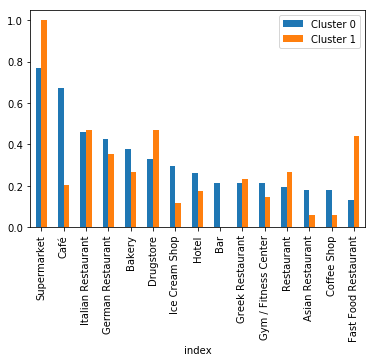

In [81]:
counts.plot.bar()

The plot confirms our first observation that Cluster 1 is dominated by supermarkets, drugstores and fast food restaurants, suggesting that it is a lower-class residential area. Cluster 0 on the other hand has many more cafes, bars and coffee shops. So these are the areas we are interested in.

## Density

In order to figure out which neighbourhoods in cluster 0 are not already saturated with venues, we will look at the venue density. Lets make a new DataFrame with only the relevant information

In [90]:
cluster_dens = berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0, 2] + list(range(berlin_merged.shape[1]-2, berlin_merged.shape[1]))]]
cluster_dens.head()

,Neighbourhood,Population,N_venues,Venue Density
0,Mitte,101.932,88,0.863321
1,Moabit,79.512,93,1.169635
2,Hansaviertel,5.894,16,2.714625
3,Tiergarten,14.753,84,5.693757
4,Wedding,86.688,94,1.084348


Sort the DataFrame.

In [92]:
cluster_dens.sort_values(by=['Venue Density', 'N_venues'])

,Neighbourhood,Population,N_venues,Venue Density
35,Falkenhagener Feld,38.592,8,0.207297
85,Reinickendorf,83.447,25,0.299591
94,Märkisches Viertel,40.258,23,0.571315
10,Blankenburg,6.865,4,0.582666
8,Prenzlauer Berg,164.593,96,0.583257
50,Neukölln,166.126,98,0.589914
7,Kreuzberg,154.862,96,0.619907
54,Gropiusstadt,37.450,24,0.640854
71,Biesdorf,27.723,18,0.649280
6,Friedrichshain,134.900,99,0.733877
